In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Importing needed libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# Mnist comes with Keras by default so simply load the test and train files using the codes below

mnist= keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:

# Let's have a look at the shape of the datasets

print("Training data: {}, {}".format(train_images.shape, train_labels.shape))
# prints Training data: (60000, 28, 28), (60000,)
print("Test data: {}, {}".format(test_images.shape, test_labels.shape))
# prints Test data: (10000, 28, 28), (10000,)

Training data: (60000, 28, 28), (60000,)
Test data: (10000, 28, 28), (10000,)


In [4]:
class_labels = np.unique(train_labels)
print("There are {} classes in the dataset. They are: {}".format(len(class_labels), class_labels))

There are 10 classes in the dataset. They are: [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Label: 5')

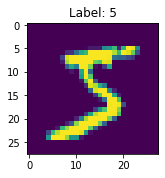

In [5]:
# Let's plot and look at a few images 

plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(train_images[0])
plt.title("Label: {}".format(train_labels[0]))

Text(0.5, 1.0, 'Label: 0')

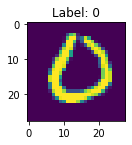

In [6]:
plt.subplot(1,3,2)
plt.imshow(train_images[2500])
plt.title("Label: {}".format(train_labels[2500]))

     

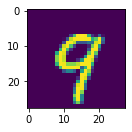

In [7]:
plt.subplot(1,3,3)
plt.imshow(test_images[12])
plt.show()

In [8]:
# As usual, we scale our dataset to range between 0 and 1. In this dataset, the pixel values range from 0 to 255.
# Dividing the data by 255 scales to the required range. This normalization is done to help with the training.

train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
x_train = train_images[0:50000]
x_val = train_images[50000:]
y_train = train_labels[0:50000]
y_val = train_labels[50000:]

print("x_train: {}".format(x_train.shape)) # prints x_train: (50000, 28, 28)
print("x_val: {}".format(x_val.shape)) # prints x_val: (10000, 28, 28)
print("y_train: {}".format(y_train.shape)) #prints y_train: (50000,)
print("y_val: {}".format(y_val.shape)) #prints y_val: (10000,)
     
x_train: (50000, 28, 28)

x_train: (50000, 28, 28)
x_val: (10000, 28, 28)
y_train: (50000,)
y_val: (10000,)


In [10]:
# one-hot encoding using keras' numpy-related utilities

from tensorflow.keras.utils import to_categorical
no_labels = 10
y_train = to_categorical(y_train, no_labels)
y_val = to_categorical(y_val, no_labels)
y_test = to_categorical(test_labels, no_labels)
     

In [11]:
# Flattening the images from the 2D 28x28 pixels to 1D 784 pixels

new_dimension = np.prod(train_images.shape[1:])
x_train = x_train.reshape(x_train.shape[0], new_dimension)
x_val = x_val.reshape(x_val.shape[0], new_dimension)
test_images = test_images.reshape(test_images.shape[0], new_dimension)

print("x_train: {}".format(x_train.shape)) #prints  x_train: (50000, 784)
print("x_val: {}".format(x_val.shape)) #prints x_val: (10000, 784)
print("test_images: {}".format(test_images.shape)) #prints test_images: (10000, 784)

x_train: (50000, 784)
x_val: (10000, 784)
test_images: (10000, 784)


In [12]:
# inputs
#placeholders are not enabled in tf 2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32, [None, new_dimension])
Y = tf.placeholder(tf.float32, [None, no_labels])

In [13]:

# create model architecture
def multilayer_perceptron(x, no_classes, first_layer_neurons=256, second_layer_neurons=128):
  # first layer
  first_weight = tf.Variable(tf.random_uniform([new_dimension, first_layer_neurons]))
  first_bias = tf.Variable(tf.zeros([first_layer_neurons]))
  first_layer_output = tf.nn.relu(tf.add(tf.matmul(x, first_weight), first_bias))
  # second layer
  second_weight = tf.Variable(tf.random_uniform([first_layer_neurons,second_layer_neurons]))
  second_bias = tf.Variable(tf.zeros([second_layer_neurons]))
  second_layer_output = tf.nn.relu(tf.add(tf.matmul(first_layer_output, second_weight), second_bias))
  # output layer
  final_weight = tf.Variable(tf.random_uniform([second_layer_neurons, no_classes]))
  final_bias = tf.Variable(tf.zeros([no_classes]))
  logits = tf.add(tf.matmul(second_layer_output, final_weight), final_bias)

  return logits

In [14]:
     

logits = multilayer_perceptron(X, no_labels)
learning_rate = 0.01
#we define the loss and optimiser for the network
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimiser.minimize(loss_op)

In [15]:
#initialise the variables
init = tf.global_variables_initializer()

epochs = 20
batch_size = 1000
iteration = len(x_train) // batch_size
#train model
with tf.Session() as session:
  session.run(init)
  for epoch in range(epochs):
    average_cost = 0
    start, end = 0, batch_size
    for i in range(iteration):
      batch_x, batch_y = x_train[start: end], y_train[start: end]
      _, loss = session.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
      start += batch_size
      end += batch_size 
      #average loss
      average_cost += loss/iteration
    print("Epoch========{}".format(epoch))
    #evaluate model
  prediction = tf.nn.softmax(logits)
  ground_truth = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(ground_truth, "float"))
  print("Accuracy: {}".format(accuracy.eval({X: test_images, Y: y_test})))
    

2023-01-13 18:06:40.943418: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch========0
Epoch========1
Epoch========2
Epoch========3
Epoch========4
Epoch========5
Epoch========6
Epoch========7
Epoch========8
Epoch========9
Epoch========10
Epoch========11
Epoch========12
Epoch========13
Epoch========14
Epoch========15
Epoch========16
Epoch========17
Epoch========18
Epoch========19
Accuracy: 0.9114999771118164


In [16]:
#Building a Sequential Feed Forward Network in Keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#Build the model object
model = Sequential()
# Build the input and the hidden layers
model.add(Dense(256, activation='relu', input_shape=(new_dimension,)))
model.add(Dense(128, activation='relu'))
# Build the output layer
model.add(Dense(no_labels, activation='softmax'))


In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])


In [18]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=1000)

test_loss, test_accuracy = model.evaluate(test_images, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 1s 22us/sample - loss: 0.6780 - acc: 0.8173 - val_loss: 0.2661 - val_acc: 0.9258
Epoch 2/20
 1000/50000 [..............................] - ETA: 0s - loss: 0.2654 - acc: 0.9260

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


50000/50000 [==============================] - 1s 17us/sample - loss: 0.2396 - acc: 0.9306 - val_loss: 0.1940 - val_acc: 0.9489
Epoch 3/20
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1784 - acc: 0.9490 - val_loss: 0.1588 - val_acc: 0.9569
Epoch 4/20
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1389 - acc: 0.9606 - val_loss: 0.1304 - val_acc: 0.9642
Epoch 5/20
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1104 - acc: 0.9689 - val_loss: 0.1174 - val_acc: 0.9667
Epoch 6/20
50000/50000 [==============================] - 1s 19us/sample - loss: 0.0932 - acc: 0.9736 - val_loss: 0.1047 - val_acc: 0.9697
Epoch 7/20
50000/50000 [==============================] - 1s 18us/sample - loss: 0.0769 - acc: 0.9779 - val_loss: 0.1004 - val_acc: 0.9709
Epoch 8/20
50000/50000 [==============================] - 1s 17us/sample - loss: 0.0652 - acc: 0.9816 - val_loss: 0.0917 - val_acc: 0.9720
Epoch 9/20
50000/50000 [==============

Text(0.5, 1.0, 'Loss Curves - before regularisation')

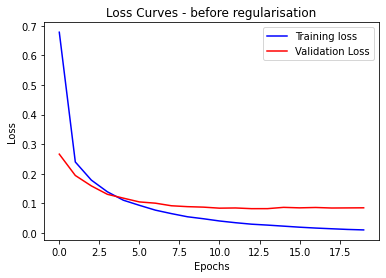

In [19]:
#Check for Overfitting

plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - before regularisation')


In [20]:
from tensorflow.keras.layers import Dropout
reg_model = Sequential()
reg_model.add(Dense(256, activation='relu', input_shape=(new_dimension,)))
reg_model.add(Dropout(0.4))
reg_model.add(Dense(128, activation='relu'))
reg_model.add(Dropout(0.4))
reg_model.add(Dense(no_labels, activation='softmax'))

reg_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

reg_history = reg_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                            epochs=20, batch_size=1000)
test_loss, test_accuracy = reg_model.evaluate(test_images, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 1s 27us/sample - loss: 0.9633 - acc: 0.6940 - val_loss: 0.2946 - val_acc: 0.9166
Epoch 2/20
50000/50000 [==============================] - 2s 33us/sample - loss: 0.3749 - acc: 0.8893 - val_loss: 0.2008 - val_acc: 0.9417
Epoch 3/20
50000/50000 [==============================] - 1s 26us/sample - loss: 0.2773 - acc: 0.9188 - val_loss: 0.1586 - val_acc: 0.9540
Epoch 4/20
50000/50000 [==============================] - 1s 22us/sample - loss: 0.2329 - acc: 0.9323 - val_loss: 0.1358 - val_acc: 0.9619
Epoch 5/20
50000/50000 [==============================] - 1s 22us/sample - loss: 0.1965 - acc: 0.9422 - val_loss: 0.1206 - val_acc: 0.9654
Epoch 6/20
50000/50000 [==============================] - 1s 22us/sample - loss: 0.1758 - acc: 0.9491 - val_loss: 0.1109 - val_acc: 0.9688
Epoch 7/20
50000/50000 [==============================] - 1s 23us/sample - loss: 0.1562 - acc: 0.9544 - val_loss: 0.

In [21]:
test_loss, test_accuracy = reg_model.evaluate(test_images, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

Test loss: 0.07025145813062554
Test accuracy: 0.9797000288963318


Text(0.5, 1.0, 'Loss Curves - after regularisation')

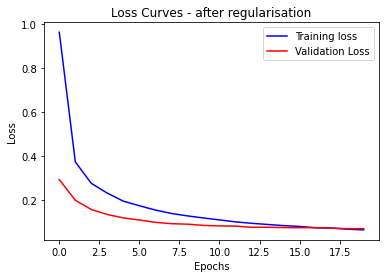

In [22]:
plt.figure()
plt.plot(reg_history.history['loss'], 'blue')
plt.plot(reg_history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after regularisation')

In [23]:
predictions = model.predict([test_images]) # Make prediction
print(np.argmax(predictions[1000])) # Print out 9
     

9


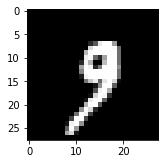

In [24]:
# Let's see whether the image would turn out to be 9
# Remember that the input data to the network were flattened for the purpose of learning to a vector with a length of 784. Before displaying it, we need to convert it back to the size of 28 x 28 pixels.
plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(test_images[1000].reshape(28,28), cmap="gray") # Import the image
plt.show() # Show the image

In [25]:
predictions = model.predict([test_images]) # Make prediction
print(np.argmax(predictions[6700])) # Print out the number

4


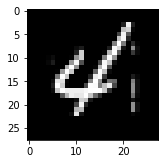

In [26]:
plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(test_images[6700].reshape(28,28), cmap="gray") # Import the image
plt.show() # Show the image